<h2>Why use Cuda?</h2>
<h5>Cuda perform compute-intensive operations faster by parallelizing tasks across GPUs </h5>

In [49]:
import torch
 
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(torch.version.cuda)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Is CUDA supported by this system? True
11.8
cuda


<h1>Zero to Mastery Learn PyTorch for Deep Learning </h1>
<a href="https://www.learnpytorch.io/04_pytorch_custom_datasets/">link to source</a>


<h2></h2>

<h2>Data Preparation is paramount</h2>
<h5>Before starting a project or building any kind of model, it's important to know what data you're working with</h5>
<h5>In this case, this is image classification, where we have images in seperate directories titled with a particular class</h5>
<h5>The goal will be to <b>take this data storage structure and turn it into a dataset usable with PyTorch</b></h5>

In [50]:
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "train"

# Check if the image folder does exist
if image_path.is_dir():
    print(f"{image_path} directory exists")
else:
    print(f"{image_path} does not exist")

data/train directory exists


<h5>We can inspect what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present</h5>

In [51]:
import os
def walk_through_dir(dir_path):
    """
        Walks through dir_path returning its contents.
        Args:
            dir_path (str or pathlib.Path): target directory
        
        Returns:
            A print out of:
            number of subdiretories in dir_path
            number of images (files) in each subdirectory
            name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(image_path)

There are 70 directories and 0 images in 'data/train'.
There are 0 directories and 98 images in 'data/train/Rottweiler'.
There are 0 directories and 129 images in 'data/train/Maltese'.
There are 0 directories and 88 images in 'data/train/Dalmation'.
There are 0 directories and 122 images in 'data/train/Dhole'.
There are 0 directories and 109 images in 'data/train/Greyhound'.
There are 0 directories and 198 images in 'data/train/Shih-Tzu'.
There are 0 directories and 125 images in 'data/train/Rhodesian'.
There are 0 directories and 65 images in 'data/train/American Hairless'.
There are 0 directories and 93 images in 'data/train/French Bulldog'.
There are 0 directories and 113 images in 'data/train/Corgi'.
There are 0 directories and 103 images in 'data/train/Pekinese'.
There are 0 directories and 128 images in 'data/train/Bull Mastiff'.
There are 0 directories and 147 images in 'data/train/Bloodhound'.
There are 0 directories and 150 images in 'data/train/Scotch Terrier'.
There are 0 di

<h5>Setup our training and testing paths</h5>

In [52]:
train_dir = "data/train"
test_dir = "data/test"
valid_dir = "data/valid/"
train_dir,test_dir,valid_dir

('data/train', 'data/test', 'data/valid/')

<h2>Visualize an image</h2>
<h5>We've seen how our directory structure is formatted. Now in the spirit of the data explorer, it's time to visualize, visualize, visualize!</h5>
<ol>
    <li>Get all of the image paths using pathlib.Path.glob() to find all of the files ending in .jpg</li>
    <li>Pick a random image path using Python's random.choice()</li>
    <li>Get the image class name using pathlib.Path.parent.stem</li>
    <li>And since we're working with images, we'll open the random image path using PIL.Image.open() (PIL stands for Python Image Library)</li>
    <li>We'll then show the image and print some metadata</li>
</ol>


In [53]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)
# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")

Random image path: data/train/Basenji/74.jpg
Image class: Basenji
Image height: 224
Image width: 224


<h5>We can do the same with matplotlib.pyplot.imshow(), except we have to convert the image to a NumPy array first</h5>

(-0.5, 223.5, 223.5, -0.5)

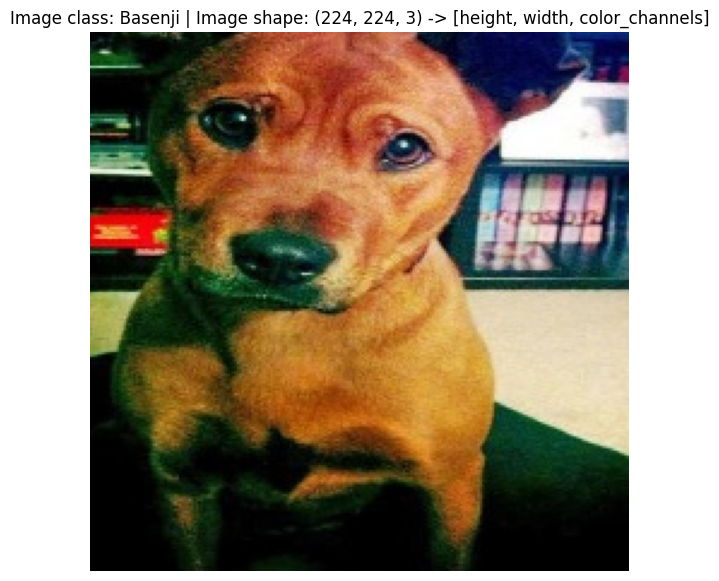

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

<h2>Transforming data</h2>

Before we can use our image data with PyTorch we need to:

1. Turn it into tensors (numerical representations of our images).
2. Turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader, we'll call these Dataset and DataLoader for short.

In [55]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Transforming data with torchvision.transforms

We've got folders of images but before we can use them with PyTorch, we need to convert them into tensors.
One of the ways we can do this is by using the torchvision.transforms module.


To get experience with torchvision.transforms, let's write a series of transform steps that:

1. Resize the images using transforms.Resize() (from about 512x512 to 64x64, the same shape as the images on the CNN Explainer website).
2. Flip our images randomly on the horizontal using transforms.RandomHorizontalFlip() (this could be considered a form of data augmentation because it will artificially change our image data).
3. Turn our images from a PIL image to a PyTorch tensor using transforms.ToTensor().


In [56]:
# Write tranforms for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64,64)), # ** More pixels require more computations **
    # Flip images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip,  0.5 = 50% chance
    # Turn the image to a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from from 0 to 255 to be between 0.0 and 1.0 
])

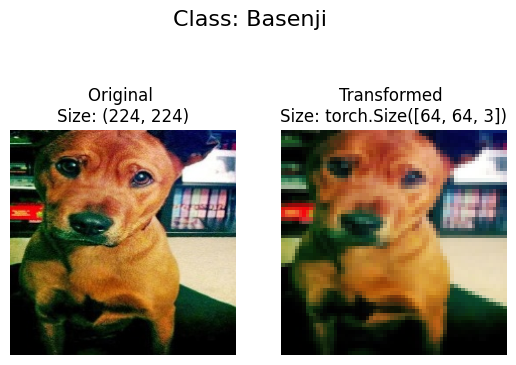

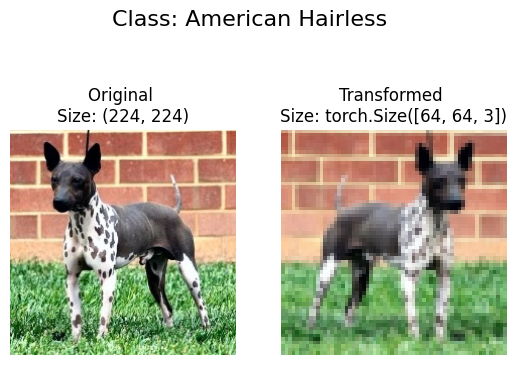

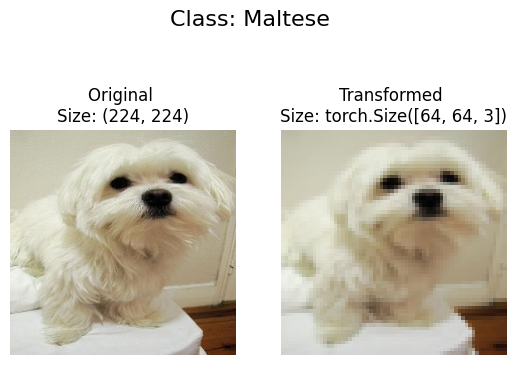

In [57]:
def plot_transformed_image(image_paths, transform, n = 3, seed = 42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k = n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
            
plot_transformed_image(image_path_list, transform=data_transform, n=3)

## Loading Image Data Using ImageFolder

Alright, time to turn our image data into a Dataset capable of being used with PyTorch.

Since our data is in standard image classification format, we can use the class torchvision.datasets.ImageFolder.

In [58]:
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None # transforms to perform on labels (if necessary)
                                )
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform
)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 7946
    Root location: data/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 700
    Root location: data/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


Let's inspect them by checking out the classes and class_to_idx attributes as well as the lengths of our training and test sets.

In [59]:
# Get classes names as list
class_names = train_data.classes
class_names

['Afghan',
 'African Wild Dog',
 'Airedale',
 'American Hairless',
 'American Spaniel',
 'Basenji',
 'Basset',
 'Beagle',
 'Bearded Collie',
 'Bermaise',
 'Bichon Frise',
 'Blenheim',
 'Bloodhound',
 'Bluetick',
 'Border Collie',
 'Borzoi',
 'Boston Terrier',
 'Boxer',
 'Bull Mastiff',
 'Bull Terrier',
 'Bulldog',
 'Cairn',
 'Chihuahua',
 'Chinese Crested',
 'Chow',
 'Clumber',
 'Cockapoo',
 'Cocker',
 'Collie',
 'Corgi',
 'Coyote',
 'Dalmation',
 'Dhole',
 'Dingo',
 'Doberman',
 'Elk Hound',
 'French Bulldog',
 'German Sheperd',
 'Golden Retriever',
 'Great Dane',
 'Great Perenees',
 'Greyhound',
 'Groenendael',
 'Irish Spaniel',
 'Irish Wolfhound',
 'Japanese Spaniel',
 'Komondor',
 'Labradoodle',
 'Labrador',
 'Lhasa',
 'Malinois',
 'Maltese',
 'Mex Hairless',
 'Newfoundland',
 'Pekinese',
 'Pit Bull',
 'Pomeranian',
 'Poodle',
 'Pug',
 'Rhodesian',
 'Rottweiler',
 'Saint Bernard',
 'Schnauzer',
 'Scotch Terrier',
 'Shar_Pei',
 'Shiba Inu',
 'Shih-Tzu',
 'Siberian Husky',
 'Vizsla',

In [60]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'Afghan': 0,
 'African Wild Dog': 1,
 'Airedale': 2,
 'American Hairless': 3,
 'American Spaniel': 4,
 'Basenji': 5,
 'Basset': 6,
 'Beagle': 7,
 'Bearded Collie': 8,
 'Bermaise': 9,
 'Bichon Frise': 10,
 'Blenheim': 11,
 'Bloodhound': 12,
 'Bluetick': 13,
 'Border Collie': 14,
 'Borzoi': 15,
 'Boston Terrier': 16,
 'Boxer': 17,
 'Bull Mastiff': 18,
 'Bull Terrier': 19,
 'Bulldog': 20,
 'Cairn': 21,
 'Chihuahua': 22,
 'Chinese Crested': 23,
 'Chow': 24,
 'Clumber': 25,
 'Cockapoo': 26,
 'Cocker': 27,
 'Collie': 28,
 'Corgi': 29,
 'Coyote': 30,
 'Dalmation': 31,
 'Dhole': 32,
 'Dingo': 33,
 'Doberman': 34,
 'Elk Hound': 35,
 'French Bulldog': 36,
 'German Sheperd': 37,
 'Golden Retriever': 38,
 'Great Dane': 39,
 'Great Perenees': 40,
 'Greyhound': 41,
 'Groenendael': 42,
 'Irish Spaniel': 43,
 'Irish Wolfhound': 44,
 'Japanese Spaniel': 45,
 'Komondor': 46,
 'Labradoodle': 47,
 'Labrador': 48,
 'Lhasa': 49,
 'Malinois': 50,
 'Maltese': 51,
 'Mex Hairless': 52,
 'Newfoundland': 53,
 'P

In [61]:
# Check lengths
len(train_data), len(test_data)

(7946, 700)

We can index on our train_data and test_data Dataset's to find samples and their target labels.

In [62]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.4039, 0.4392, 0.4706,  ..., 0.2275, 0.2667, 0.2667],
         [0.3725, 0.3608, 0.4039,  ..., 0.1569, 0.1686, 0.1686],
         [0.3882, 0.3922, 0.4863,  ..., 0.1255, 0.1255, 0.1216],
         ...,
         [0.4000, 0.3843, 0.3647,  ..., 0.6706, 0.5961, 0.5216],
         [0.3686, 0.3490, 0.3412,  ..., 0.6078, 0.4824, 0.4157],
         [0.3569, 0.3333, 0.3216,  ..., 0.5098, 0.3725, 0.2980]],

        [[0.4784, 0.5176, 0.5451,  ..., 0.2784, 0.3216, 0.3216],
         [0.4392, 0.4392, 0.4941,  ..., 0.2000, 0.2157, 0.2196],
         [0.4588, 0.4706, 0.5725,  ..., 0.1451, 0.1490, 0.1569],
         ...,
         [0.5176, 0.5020, 0.4863,  ..., 0.5490, 0.5216, 0.5059],
         [0.4902, 0.4706, 0.4627,  ..., 0.5176, 0.4667, 0.4588],
         [0.4784, 0.4549, 0.4431,  ..., 0.4549, 0.4000, 0.3686]],

        [[0.2588, 0.2863, 0.3137,  ..., 0.1098, 0.1216, 0.1216],
         [0.2353, 0.2078, 0.2392,  ..., 0.0824, 0.0706, 0.0627],
         [0.2510, 0.2392, 0.3294,  ..., 0.07

Our images are now in the form of a tensor (with shape [3, 64, 64]) and the labels are in the form of an integer relating to a specific class (as referenced by the class_to_idx attribute).

How about we plot a single image tensor using matplotlib?

We'll first have to to permute (rearrange the order of its dimensions) so it's compatible.

Right now our image dimensions are in the format CHW (color channels, height, width) but matplotlib prefers HWC (height, width, color channels).

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


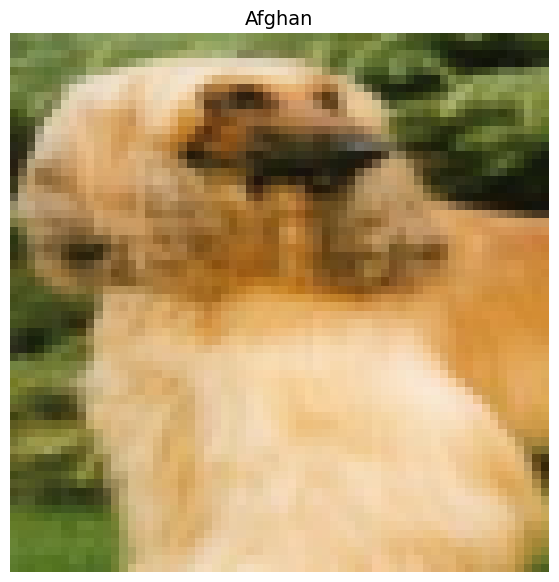

In [63]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

### Turn loaded images into DataLoader's

We've got our images as PyTorch Dataset's but now let's turn them into DataLoader's.

We'll do so using torch.utils.data.DataLoader.

Turning our Dataset's into DataLoader's makes them iterable so a model can go through learn the relationships between samples and targets (features and labels).

In [64]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more  more compute power PyTorch will use to load your data) usually set it to the total number of CPUs on my machine via Python's os.cpu_count()
                              shuffle=True # shuffle the data?
)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False # don't usually need to shuffle testing data
                             )
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f842be99f90>,
 <torch.utils.data.dataloader.DataLoader at 0x7f842be9a110>)

Now our data is iterable.

Let's try it out and check the shapes.

In [65]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the bacth_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


### Create TinyVGG model class

Let's build a model - https://www.learnpytorch.io/04_pytorch_custom_datasets/#72-create-tinyvgg-model-class

We'll be using color images instead of grayscale (in_channels=3 instead of in_channels=1 for RGB pixels).

In [66]:
import torch.nn as nn
import torch.nn.functional as F
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    
    """

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 128, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Dropout(p=0.2)
        ) 
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 64, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Dropout(p=0.2)
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Dropout(p=0.2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=2304,
                      out_features=70)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.classifier(x)
      
        return x
    # def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    #     super().__init__()
    #     self.conv_block_1 = nn.Sequential(
    #         nn.Conv2d(in_channels=input_shape, 
    #                   out_channels=hidden_units, 
    #                   kernel_size=3, # how big is the square that's going over the image?
    #                   stride=1, # default
    #                   padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
    #         nn.ReLU(),
    #         nn.Conv2d(in_channels=hidden_units, 
    #                   out_channels=hidden_units,
    #                   kernel_size=3,
    #                   stride=1,
    #                   padding=1),
    #         nn.ReLU(),
    #         nn.MaxPool2d(kernel_size=2,
    #                      stride=2) # default stride value is same as kernel_size
    #     )
    #     self.conv_block_2 = nn.Sequential(
    #         nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
    #         nn.ReLU(),
    #         nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
    #         nn.ReLU(),
    #         nn.MaxPool2d(2)
    #     )

    #     self.classifier = nn.Sequential(
    #         nn.Flatten(),
    #         # Where did this in_features shape come from? 
    #         # It's because each layer of our network compresses and changes the shape of our inputs data.
    #         nn.Linear(in_features=hidden_units*16*16,
    #                   out_features=output_shape)
    #     )
    
    # def forward(self, x: torch.Tensor):
    #     x = self.conv_block_1(x)
    #     # print(x.shape)
    #     x = self.conv_block_2(x)
    #     # print(x.shape)        
    #     x = self.classifier(x)
    #     # print(x.shape)
    #     return x
    #     # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

# torch.manual_seed(42)
# model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
#                   hidden_units=10, 
#                   output_shape=len(train_data.classes)).to(device)
# model_0

In [67]:
# from torchinfo import summary
# summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size 

### Try a forward pass on a single image (to test the model)

To do a forward pass on a single image, let's:

1. Get a batch of images and labels from the `DataLoader`.
2. Get a single image from the batch and `unsqueeze()` the image so it has a batch size of `1` (so its shape fits the model).
3. Perform inference on a single image (making sure to send the image to the target `device`).
4. Print out what's happening and convert the model's raw output logits to prediction probabilities with `torch.softmax()` (since we're working with multi-class data) and convert the prediction probabilities to prediction labels with `torch.argmax()`.

In [68]:
# # 1. Get a batch of images and labels from the DataLoader
# img_batch, label_batch = next(iter(train_dataloader))

# # 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
# img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0].unsqueeze(dim=0)
# print(f"Single image shape: {img_single.shape}\n")

# # 3. Perform a forward pass on a single image
# model_0.eval()
# with torch.inference_mode():
#     pred = model_0(img_single.to(device))

# # 4. Print out what's happening and convert model logits -> pred probs -> pred label
# print(f"Output logits:\n{pred}\n")
# print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
# print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
# print(f"Actual label:\n{label_single}")

### Create train & test loop functions

Specifically, we're going to make three functions:

1. `train_step()` - takes in a model, a `DataLoader`, a loss function and an optimizer and trains the model on the `DataLoader`.
2. `test_step()` - takes in a model, a `DataLoader` and a loss function and evaluates the model on the `DataLoader`.
3. `train()` - performs 1. and 2. together for a given number of epochs and returns a results dictionary.

Let's start by building train_step().

In [69]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer
               ):
    
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0,0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward 
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumalate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
    
    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

Now let's do the same for the `test_step()` function.

The main difference here will be the `test_step()` won't take in an optimizer and therefore won't perform gradient descent.

But since we'll be doing inference, we'll make sure to turn on the `torch.inference_mode()` context manager for making predictions.

In [70]:
def test_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):
    
       # Put model in eval mode
       model.eval()

       # Setup test loss and test accuracy values
       test_loss, test_acc = 0, 0

       # Turn on inference context manager
       with torch.inference_mode():
              # Loop through the DataLoader batches
              for batch, (X, y) in enumerate(dataloader):
                     # Send data to target devices
                     X, y = X.to(device), y.to(device)

                     # 1. Forward pass
                     test_pred_logits = model(X)

                     # 2. Calculate and accumulate loss
                     loss = loss_fn(test_pred_logits, y)
                     test_loss += loss.item()

                     # Calculate and accumulate the accuracy 
                     test_pred_labels = test_pred_logits.argmax(dim=1)
                     test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))
                     
       # Adjust metrics to get average loss and accuracy per batch 
       test_loss = test_loss / len(dataloader)
       test_acc = test_acc / len(dataloader)
       return test_loss, test_acc

### Creating a `train()` function to combine `train_step()` and `test_step()`

Now we need a way to put our `train_step()` and `test_step()` functions together.

To do so, we'll package them up in a `train()` function.

This function will train the model as well as evaluate it.

Specificially, it'll:

1. Take in a model, a `DataLoader` for training and test sets, an optimizer, a loss function and how many epochs to perform each train and test step for.
2. Create an empty results dictionary for `train_loss`, `train_acc`, `test_loss` and `test_acc` values (we can fill this up as training goes on).
3. Loop through the training and test step functions for a number of epochs.
4. Print out what's happening at the end of each epoch.
5. Update the empty results dictionary with the updated metrics each epoch.
6. Return the filled

In [71]:
from tqdm import tqdm


# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create a empty dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
     # 4. Print out what's happening
        # if epoch % 10 == 0:
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results


### Train and Evaluate Model 0

To keep our experiments quick, we'll train our model for **5 epochs** (though you could increase this if you want).

As for an **optimizer** and **loss function**, we'll use `torch.nn.CrossEntropyLoss()` (since we're working with multi-class classification data) and `torch.optim.Adam()` with a learning rate of 1e-3 respecitvely.

To see how long things take, we'll import Python's `timeit.default_timer()` method to calculate the training time.

In [72]:
# Set up random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 100

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=8, # reduced the number of hidden layers
                  output_shape=len(train_data.classes)).to(device)

# Set up the loss function and optimizer 
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.001, momentum=0.9)

# Start timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  1%|          | 1/100 [00:27<45:15, 27.43s/it]

Epoch: 1 | train_loss: 4.1229 | train_acc: 0.0340 | test_loss: 3.8574 | test_acc: 0.0500


  2%|▏         | 2/100 [00:54<44:26, 27.21s/it]

Epoch: 2 | train_loss: 3.7273 | train_acc: 0.0928 | test_loss: 3.4227 | test_acc: 0.1443


  3%|▎         | 3/100 [01:20<43:13, 26.74s/it]

Epoch: 3 | train_loss: 3.4094 | train_acc: 0.1542 | test_loss: 3.2719 | test_acc: 0.1814


  4%|▍         | 4/100 [01:46<42:19, 26.45s/it]

Epoch: 4 | train_loss: 3.1610 | train_acc: 0.2039 | test_loss: 3.0600 | test_acc: 0.2157


  5%|▌         | 5/100 [02:12<41:26, 26.18s/it]

Epoch: 5 | train_loss: 2.9663 | train_acc: 0.2542 | test_loss: 2.9522 | test_acc: 0.2486


  6%|▌         | 6/100 [02:37<40:18, 25.73s/it]

Epoch: 6 | train_loss: 2.8145 | train_acc: 0.2723 | test_loss: 2.8293 | test_acc: 0.2729


  7%|▋         | 7/100 [03:02<39:32, 25.51s/it]

Epoch: 7 | train_loss: 2.6825 | train_acc: 0.3158 | test_loss: 2.7650 | test_acc: 0.2957


  8%|▊         | 8/100 [03:27<38:52, 25.35s/it]

Epoch: 8 | train_loss: 2.5794 | train_acc: 0.3385 | test_loss: 2.8457 | test_acc: 0.2886


  9%|▉         | 9/100 [03:53<38:41, 25.51s/it]

Epoch: 9 | train_loss: 2.5044 | train_acc: 0.3521 | test_loss: 2.7506 | test_acc: 0.3229


 10%|█         | 10/100 [04:18<38:00, 25.34s/it]

Epoch: 10 | train_loss: 2.4541 | train_acc: 0.3583 | test_loss: 2.7094 | test_acc: 0.3100


 11%|█         | 11/100 [04:43<37:41, 25.41s/it]

Epoch: 11 | train_loss: 2.4138 | train_acc: 0.3762 | test_loss: 2.7372 | test_acc: 0.2857


 12%|█▏        | 12/100 [05:08<37:04, 25.28s/it]

Epoch: 12 | train_loss: 2.3110 | train_acc: 0.3916 | test_loss: 2.6952 | test_acc: 0.3286


 13%|█▎        | 13/100 [05:33<36:31, 25.19s/it]

Epoch: 13 | train_loss: 2.3157 | train_acc: 0.3986 | test_loss: 2.7733 | test_acc: 0.3029


 14%|█▍        | 14/100 [05:58<36:01, 25.14s/it]

Epoch: 14 | train_loss: 2.2659 | train_acc: 0.4072 | test_loss: 2.7485 | test_acc: 0.3157


 15%|█▌        | 15/100 [06:23<35:37, 25.14s/it]

Epoch: 15 | train_loss: 2.2426 | train_acc: 0.4096 | test_loss: 2.7240 | test_acc: 0.3386


 16%|█▌        | 16/100 [06:49<35:31, 25.37s/it]

Epoch: 16 | train_loss: 2.2524 | train_acc: 0.4139 | test_loss: 2.8192 | test_acc: 0.2929


 17%|█▋        | 17/100 [07:15<35:11, 25.44s/it]

Epoch: 17 | train_loss: 2.1721 | train_acc: 0.4257 | test_loss: 2.9603 | test_acc: 0.2600


 18%|█▊        | 18/100 [07:40<34:33, 25.28s/it]

Epoch: 18 | train_loss: 2.1820 | train_acc: 0.4276 | test_loss: 2.8396 | test_acc: 0.2857


 19%|█▉        | 19/100 [08:04<33:54, 25.12s/it]

Epoch: 19 | train_loss: 2.1553 | train_acc: 0.4289 | test_loss: 2.9814 | test_acc: 0.2871


 20%|██        | 20/100 [08:30<33:39, 25.25s/it]

Epoch: 20 | train_loss: 2.1650 | train_acc: 0.4338 | test_loss: 2.8804 | test_acc: 0.3043


 21%|██        | 21/100 [08:55<33:04, 25.12s/it]

Epoch: 21 | train_loss: 2.1310 | train_acc: 0.4396 | test_loss: 2.9509 | test_acc: 0.3229


 22%|██▏       | 22/100 [09:20<32:29, 24.99s/it]

Epoch: 22 | train_loss: 2.1138 | train_acc: 0.4401 | test_loss: 3.1587 | test_acc: 0.2757


 23%|██▎       | 23/100 [09:45<32:17, 25.16s/it]

Epoch: 23 | train_loss: 2.1232 | train_acc: 0.4353 | test_loss: 2.8757 | test_acc: 0.2714


 24%|██▍       | 24/100 [10:10<31:38, 24.98s/it]

Epoch: 24 | train_loss: 2.1031 | train_acc: 0.4463 | test_loss: 2.7901 | test_acc: 0.3257


 25%|██▌       | 25/100 [10:35<31:28, 25.18s/it]

Epoch: 25 | train_loss: 2.0931 | train_acc: 0.4499 | test_loss: 2.9946 | test_acc: 0.2714


 26%|██▌       | 26/100 [11:00<30:52, 25.03s/it]

Epoch: 26 | train_loss: 2.0835 | train_acc: 0.4517 | test_loss: 3.2805 | test_acc: 0.2243


 27%|██▋       | 27/100 [11:25<30:37, 25.17s/it]

Epoch: 27 | train_loss: 2.0861 | train_acc: 0.4533 | test_loss: 3.0906 | test_acc: 0.2629


 28%|██▊       | 28/100 [11:50<30:02, 25.03s/it]

Epoch: 28 | train_loss: 2.0516 | train_acc: 0.4679 | test_loss: 3.0421 | test_acc: 0.3214


 29%|██▉       | 29/100 [12:17<30:08, 25.48s/it]

Epoch: 29 | train_loss: 2.0395 | train_acc: 0.4648 | test_loss: 3.1564 | test_acc: 0.2729


 30%|███       | 30/100 [12:42<29:31, 25.31s/it]

Epoch: 30 | train_loss: 2.0738 | train_acc: 0.4607 | test_loss: 3.0147 | test_acc: 0.3057


 31%|███       | 31/100 [13:07<29:13, 25.42s/it]

Epoch: 31 | train_loss: 2.0311 | train_acc: 0.4640 | test_loss: 3.0566 | test_acc: 0.3043


 32%|███▏      | 32/100 [13:32<28:40, 25.30s/it]

Epoch: 32 | train_loss: 2.0279 | train_acc: 0.4661 | test_loss: 3.2367 | test_acc: 0.2914


 33%|███▎      | 33/100 [13:57<28:09, 25.21s/it]

Epoch: 33 | train_loss: 2.0331 | train_acc: 0.4717 | test_loss: 3.1545 | test_acc: 0.2871


 34%|███▍      | 34/100 [14:22<27:39, 25.15s/it]

Epoch: 34 | train_loss: 2.0092 | train_acc: 0.4734 | test_loss: 3.1246 | test_acc: 0.3271


 35%|███▌      | 35/100 [14:47<27:10, 25.09s/it]

Epoch: 35 | train_loss: 2.0525 | train_acc: 0.4673 | test_loss: 2.9090 | test_acc: 0.2929


 36%|███▌      | 36/100 [15:12<26:44, 25.07s/it]

Epoch: 36 | train_loss: 2.0332 | train_acc: 0.4643 | test_loss: 3.0302 | test_acc: 0.2857


 37%|███▋      | 37/100 [15:37<26:16, 25.02s/it]

Epoch: 37 | train_loss: 2.0321 | train_acc: 0.4661 | test_loss: 3.1474 | test_acc: 0.2657


 38%|███▊      | 38/100 [16:02<25:50, 25.01s/it]

Epoch: 38 | train_loss: 1.9565 | train_acc: 0.4829 | test_loss: 3.0061 | test_acc: 0.2843


 39%|███▉      | 39/100 [16:28<25:34, 25.16s/it]

Epoch: 39 | train_loss: 1.9535 | train_acc: 0.4930 | test_loss: 3.1727 | test_acc: 0.2786


 40%|████      | 40/100 [16:54<25:22, 25.37s/it]

Epoch: 40 | train_loss: 1.9582 | train_acc: 0.4906 | test_loss: 3.1452 | test_acc: 0.3086


 41%|████      | 41/100 [17:20<25:17, 25.72s/it]

Epoch: 41 | train_loss: 1.9598 | train_acc: 0.4923 | test_loss: 3.1102 | test_acc: 0.3029


 42%|████▏     | 42/100 [17:46<24:47, 25.64s/it]

Epoch: 42 | train_loss: 1.9740 | train_acc: 0.4826 | test_loss: 3.3318 | test_acc: 0.2929


 43%|████▎     | 43/100 [18:10<24:06, 25.37s/it]

Epoch: 43 | train_loss: 1.9862 | train_acc: 0.4795 | test_loss: 3.2485 | test_acc: 0.2814


 44%|████▍     | 44/100 [18:35<23:35, 25.28s/it]

Epoch: 44 | train_loss: 2.0145 | train_acc: 0.4768 | test_loss: 3.1262 | test_acc: 0.2943


 45%|████▌     | 45/100 [19:00<23:06, 25.20s/it]

Epoch: 45 | train_loss: 1.9420 | train_acc: 0.4893 | test_loss: 3.1374 | test_acc: 0.2600


 46%|████▌     | 46/100 [19:25<22:37, 25.15s/it]

Epoch: 46 | train_loss: 1.9825 | train_acc: 0.4853 | test_loss: 3.1909 | test_acc: 0.2714


 47%|████▋     | 47/100 [19:51<22:25, 25.38s/it]

Epoch: 47 | train_loss: 1.9496 | train_acc: 0.4860 | test_loss: 3.3461 | test_acc: 0.3000


 48%|████▊     | 48/100 [20:16<21:48, 25.17s/it]

Epoch: 48 | train_loss: 1.9496 | train_acc: 0.4835 | test_loss: 3.3601 | test_acc: 0.2686


 49%|████▉     | 49/100 [20:41<21:22, 25.15s/it]

Epoch: 49 | train_loss: 1.9907 | train_acc: 0.4799 | test_loss: 3.2106 | test_acc: 0.2714


 50%|█████     | 50/100 [21:06<20:53, 25.07s/it]

Epoch: 50 | train_loss: 1.9424 | train_acc: 0.4913 | test_loss: 3.0414 | test_acc: 0.2800


 51%|█████     | 51/100 [21:31<20:28, 25.07s/it]

Epoch: 51 | train_loss: 1.9650 | train_acc: 0.4791 | test_loss: 3.1796 | test_acc: 0.3000


 52%|█████▏    | 52/100 [21:56<20:00, 25.00s/it]

Epoch: 52 | train_loss: 1.9447 | train_acc: 0.4918 | test_loss: 3.1976 | test_acc: 0.2743


 53%|█████▎    | 53/100 [22:21<19:34, 25.00s/it]

Epoch: 53 | train_loss: 1.9513 | train_acc: 0.4869 | test_loss: 3.2206 | test_acc: 0.3071


 54%|█████▍    | 54/100 [22:46<19:08, 24.98s/it]

Epoch: 54 | train_loss: 1.9816 | train_acc: 0.4863 | test_loss: 3.2137 | test_acc: 0.2871


 55%|█████▌    | 55/100 [23:11<18:44, 24.99s/it]

Epoch: 55 | train_loss: 1.9616 | train_acc: 0.4964 | test_loss: 3.1754 | test_acc: 0.2800


 56%|█████▌    | 56/100 [23:36<18:20, 25.01s/it]

Epoch: 56 | train_loss: 1.9427 | train_acc: 0.4914 | test_loss: 3.5289 | test_acc: 0.2657


 57%|█████▋    | 57/100 [24:01<17:53, 24.96s/it]

Epoch: 57 | train_loss: 1.9564 | train_acc: 0.4841 | test_loss: 3.2398 | test_acc: 0.2986


 58%|█████▊    | 58/100 [24:26<17:30, 25.01s/it]

Epoch: 58 | train_loss: 1.9508 | train_acc: 0.4894 | test_loss: 3.3712 | test_acc: 0.2871


 59%|█████▉    | 59/100 [24:51<17:03, 24.97s/it]

Epoch: 59 | train_loss: 1.9304 | train_acc: 0.4995 | test_loss: 3.4503 | test_acc: 0.3171


 60%|██████    | 60/100 [25:16<16:39, 24.99s/it]

Epoch: 60 | train_loss: 1.9093 | train_acc: 0.4938 | test_loss: 3.5407 | test_acc: 0.3029


 61%|██████    | 61/100 [25:41<16:12, 24.93s/it]

Epoch: 61 | train_loss: 1.9030 | train_acc: 0.4984 | test_loss: 3.4696 | test_acc: 0.3086


 62%|██████▏   | 62/100 [26:07<15:59, 25.24s/it]

Epoch: 62 | train_loss: 1.9180 | train_acc: 0.4936 | test_loss: 3.3947 | test_acc: 0.3143


 63%|██████▎   | 63/100 [26:32<15:31, 25.16s/it]

Epoch: 63 | train_loss: 1.9127 | train_acc: 0.5047 | test_loss: 3.2731 | test_acc: 0.3086


 64%|██████▍   | 64/100 [26:57<15:04, 25.12s/it]

Epoch: 64 | train_loss: 1.8561 | train_acc: 0.5176 | test_loss: 3.3557 | test_acc: 0.2800


 65%|██████▌   | 65/100 [27:23<14:52, 25.50s/it]

Epoch: 65 | train_loss: 1.8957 | train_acc: 0.5015 | test_loss: 3.2718 | test_acc: 0.3086


 66%|██████▌   | 66/100 [27:49<14:29, 25.57s/it]

Epoch: 66 | train_loss: 1.9538 | train_acc: 0.4916 | test_loss: 3.4542 | test_acc: 0.2686


 67%|██████▋   | 67/100 [28:14<14:02, 25.54s/it]

Epoch: 67 | train_loss: 1.8955 | train_acc: 0.5018 | test_loss: 3.5450 | test_acc: 0.2986


 68%|██████▊   | 68/100 [28:39<13:35, 25.48s/it]

Epoch: 68 | train_loss: 1.9301 | train_acc: 0.4936 | test_loss: 3.4463 | test_acc: 0.3043


 69%|██████▉   | 69/100 [29:05<13:05, 25.35s/it]

Epoch: 69 | train_loss: 1.9664 | train_acc: 0.4937 | test_loss: 3.3692 | test_acc: 0.2771


 70%|███████   | 70/100 [29:29<12:35, 25.18s/it]

Epoch: 70 | train_loss: 1.9405 | train_acc: 0.4953 | test_loss: 3.2884 | test_acc: 0.2786


 71%|███████   | 71/100 [29:54<12:09, 25.15s/it]

Epoch: 71 | train_loss: 1.9276 | train_acc: 0.4917 | test_loss: 3.7300 | test_acc: 0.2643


 72%|███████▏  | 72/100 [30:19<11:41, 25.04s/it]

Epoch: 72 | train_loss: 1.9263 | train_acc: 0.4990 | test_loss: 3.2073 | test_acc: 0.2843


 73%|███████▎  | 73/100 [30:44<11:16, 25.06s/it]

Epoch: 73 | train_loss: 1.9403 | train_acc: 0.4927 | test_loss: 3.4461 | test_acc: 0.2900


 74%|███████▍  | 74/100 [31:09<10:50, 25.01s/it]

Epoch: 74 | train_loss: 1.8332 | train_acc: 0.5179 | test_loss: 3.3845 | test_acc: 0.2771


 75%|███████▌  | 75/100 [31:34<10:24, 25.00s/it]

Epoch: 75 | train_loss: 1.8503 | train_acc: 0.5137 | test_loss: 3.5771 | test_acc: 0.2657


 76%|███████▌  | 76/100 [31:59<09:59, 24.99s/it]

Epoch: 76 | train_loss: 1.8372 | train_acc: 0.5140 | test_loss: 3.3335 | test_acc: 0.3071


 77%|███████▋  | 77/100 [32:24<09:36, 25.04s/it]

Epoch: 77 | train_loss: 1.8972 | train_acc: 0.5021 | test_loss: 3.1859 | test_acc: 0.2971


 78%|███████▊  | 78/100 [32:49<09:10, 25.04s/it]

Epoch: 78 | train_loss: 1.8957 | train_acc: 0.5052 | test_loss: 3.1774 | test_acc: 0.3343


 79%|███████▉  | 79/100 [33:14<08:44, 24.99s/it]

Epoch: 79 | train_loss: 1.9107 | train_acc: 0.5057 | test_loss: 3.4607 | test_acc: 0.2814


 80%|████████  | 80/100 [33:39<08:18, 24.94s/it]

Epoch: 80 | train_loss: 1.8996 | train_acc: 0.5093 | test_loss: 3.1980 | test_acc: 0.3471


 81%|████████  | 81/100 [34:04<07:53, 24.93s/it]

Epoch: 81 | train_loss: 1.8701 | train_acc: 0.5127 | test_loss: 3.4222 | test_acc: 0.2986


 82%|████████▏ | 82/100 [34:29<07:29, 25.00s/it]

Epoch: 82 | train_loss: 1.8597 | train_acc: 0.5159 | test_loss: 3.4662 | test_acc: 0.2914


 83%|████████▎ | 83/100 [34:54<07:04, 24.98s/it]

Epoch: 83 | train_loss: 1.8681 | train_acc: 0.5189 | test_loss: 3.3364 | test_acc: 0.2843


 84%|████████▍ | 84/100 [35:20<06:42, 25.13s/it]

Epoch: 84 | train_loss: 1.8939 | train_acc: 0.5084 | test_loss: 3.3383 | test_acc: 0.2986


 85%|████████▌ | 85/100 [35:44<06:15, 25.06s/it]

Epoch: 85 | train_loss: 1.8807 | train_acc: 0.5087 | test_loss: 3.8258 | test_acc: 0.2543


 86%|████████▌ | 86/100 [36:09<05:49, 24.99s/it]

Epoch: 86 | train_loss: 1.8929 | train_acc: 0.5089 | test_loss: 3.4702 | test_acc: 0.3214


 87%|████████▋ | 87/100 [36:34<05:25, 25.02s/it]

Epoch: 87 | train_loss: 1.8519 | train_acc: 0.5162 | test_loss: 3.3503 | test_acc: 0.3100


 88%|████████▊ | 88/100 [36:59<04:59, 24.99s/it]

Epoch: 88 | train_loss: 1.8621 | train_acc: 0.5118 | test_loss: 3.5535 | test_acc: 0.3129


 89%|████████▉ | 89/100 [37:24<04:35, 25.03s/it]

Epoch: 89 | train_loss: 1.8667 | train_acc: 0.5155 | test_loss: 3.3834 | test_acc: 0.2600


 90%|█████████ | 90/100 [37:50<04:11, 25.20s/it]

Epoch: 90 | train_loss: 1.8360 | train_acc: 0.5184 | test_loss: 3.3686 | test_acc: 0.3100


 91%|█████████ | 91/100 [38:15<03:46, 25.15s/it]

Epoch: 91 | train_loss: 1.8647 | train_acc: 0.5208 | test_loss: 3.3442 | test_acc: 0.3086


 92%|█████████▏| 92/100 [38:40<03:20, 25.10s/it]

Epoch: 92 | train_loss: 1.8721 | train_acc: 0.5188 | test_loss: 3.2801 | test_acc: 0.3014


 93%|█████████▎| 93/100 [39:05<02:55, 25.10s/it]

Epoch: 93 | train_loss: 1.8772 | train_acc: 0.5089 | test_loss: 3.6138 | test_acc: 0.2771


 94%|█████████▍| 94/100 [39:31<02:31, 25.28s/it]

Epoch: 94 | train_loss: 1.8328 | train_acc: 0.5273 | test_loss: 3.6959 | test_acc: 0.2971


 95%|█████████▌| 95/100 [39:56<02:05, 25.15s/it]

Epoch: 95 | train_loss: 1.8819 | train_acc: 0.5107 | test_loss: 3.3036 | test_acc: 0.2971


 96%|█████████▌| 96/100 [40:21<01:40, 25.10s/it]

Epoch: 96 | train_loss: 1.8960 | train_acc: 0.5091 | test_loss: 3.6571 | test_acc: 0.2914


 97%|█████████▋| 97/100 [40:48<01:17, 25.87s/it]

Epoch: 97 | train_loss: 1.8658 | train_acc: 0.5152 | test_loss: 3.8887 | test_acc: 0.2514


 98%|█████████▊| 98/100 [41:13<00:51, 25.61s/it]

Epoch: 98 | train_loss: 1.8799 | train_acc: 0.5063 | test_loss: 3.5917 | test_acc: 0.3086


 99%|█████████▉| 99/100 [41:38<00:25, 25.38s/it]

Epoch: 99 | train_loss: 1.8871 | train_acc: 0.5137 | test_loss: 3.4675 | test_acc: 0.2900


100%|██████████| 100/100 [42:03<00:00, 25.23s/it]

Epoch: 100 | train_loss: 1.8839 | train_acc: 0.5130 | test_loss: 3.3122 | test_acc: 0.2771
Total training time: 2523.449 seconds


### Plot the loss curves of Model 0

From the print outs of our model_0 training, it didn't look like it did too well.

But we can further evaluate it by plotting the model's **loss curves**.

**Loss curves** show the model's results over time.

And they're a great way to see how your model performs on different datasets (e.g. training and test).

https://www.learnpytorch.io/04_pytorch_custom_datasets/#78-plot-the-loss-curves-of-model-0

In [73]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [74]:
from typing import List, Dict
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

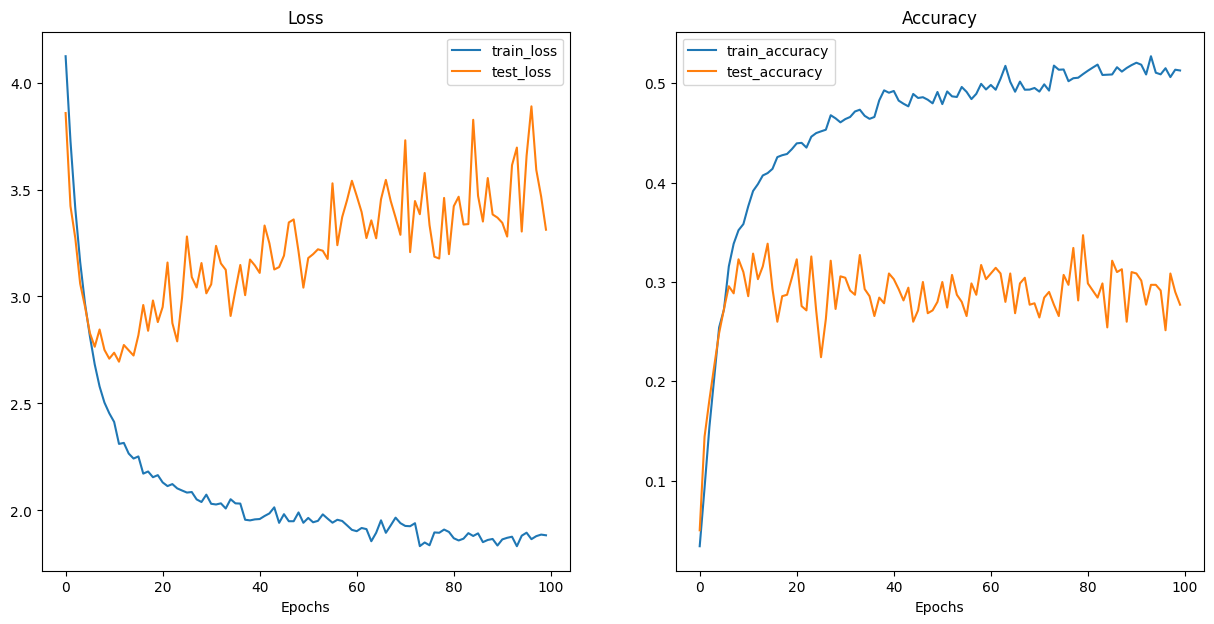

In [75]:
plot_loss_curves(model_0_results)

### What should an ideal loss curve look like
https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

In [76]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,4.122940,0.033979,3.857377,0.050000
1,3.727253,0.092751,3.422729,0.144286
2,3.409381,0.154166,3.271888,0.181429
3,3.161000,0.203876,3.059954,0.215714
4,2.966256,0.254216,2.952219,0.248571
...,...,...,...,...
95,1.895996,0.509061,3.657095,0.291429
96,1.865847,0.515228,3.888697,0.251429
97,1.879902,0.506292,3.591689,0.308571
98,1.887129,0.513718,3.467491,0.290000
